# Appendix: Benchmarking Solvers

Benchmarks on simple test structures can be used for
1. Investigation of convergence of the classical tortuosity factor with increasing voxel count. This addresses [pixelation artifacts](https://iopscience.iop.org/article/10.1149/1945-7111/ad9a07).
2. Cross-validation between various solvers to check consistency and different wall-time and RAM scaling (`Solver`, `PeriodicSolver`, `AnisotropicSolver`, `MultiPhaseSolver`).

In `utils.py`, various test structures are predefined which can directly be called by the `run_benchmark_study` function in `benchmark.py`. We first visualise the various test structures...

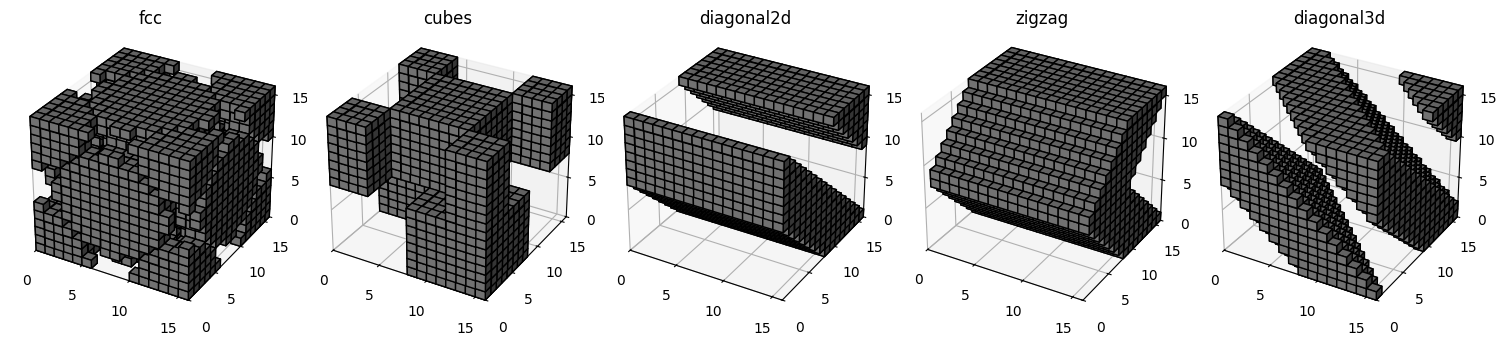

In [1]:
from taufactor.utils import create_fcc_cube, \
    create_stacked_blocks, create_2d_diagonals, \
    create_3d_diagonals, create_2d_zigzag
import matplotlib.pyplot as plt
import numpy as np

Nx = 16
fields = {}

fields["fcc"] = create_fcc_cube(Nx)
fields["cubes"] = create_stacked_blocks(Nx, features=1)
fields["diagonal2d"] = create_2d_diagonals(Nx, features=1)
fields["zigzag"] = create_2d_zigzag(Nx, features=1)
fields["diagonal3d"] = create_3d_diagonals(Nx, features=1)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4), dpi=100)
for i, structure in enumerate(fields.keys()):
    axes[i].remove()
    axes[i] = fig.add_subplot(1, 5, i + 1, projection='3d')
    axes[i].voxels(np.transpose(fields[structure], (2,1,0)), facecolors='gray', edgecolor='black', alpha=1.0)
    axes[i].set_zlim(0, Nx)
    axes[i].set_aspect('equal')
    axes[i].set_title(structure)
    axes[i].set_xlim(0, Nx)
    axes[i].set_ylim(0, Nx)
plt.tight_layout()
plt.show()

## Tau Convergence vs. Voxel Count on FCC cube

In [2]:
from taufactor.benchmark import run_benchmark_study
import pandas as pd

Ns = [32, 64, 100, 128, 200, 256, 300]
res = run_benchmark_study(
    Ns=Ns,
    devices=['cuda'],
    conv_crit_values=[1e-3],
    solver='Solver',
    write_file=False,
)

df_solver = pd.DataFrame(res).sort_values('N').reset_index(drop=True)
df_solver

,N,structure,solver,device,conv_crit,total_time,solve_time,iterations,taufactor,torch_cur,torch_max,torch_res
0,32,fcc,Solver,cuda,0.001,0.252274,0.1360,400,3.307094,0.71,1.09,2.10
1,64,fcc,Solver,cuda,0.001,0.123274,0.1001,500,2.348118,5.45,8.54,27.26
2,100,fcc,Solver,cuda,0.001,0.257616,0.2137,800,2.184316,21.22,33.14,44.04
3,128,fcc,Solver,cuda,0.001,1.535577,1.4544,1000,2.106697,42.74,67.78,85.98
4,200,fcc,Solver,cuda,0.001,11.463430,11.1590,1500,2.029747,163.11,258.63,270.53
5,256,fcc,Solver,cuda,0.001,31.733911,31.0512,2000,2.001894,339.74,540.80,547.36
6,300,fcc,Solver,cuda,0.001,60.380692,59.3636,2400,1.984324,546.30,869.22,882.90


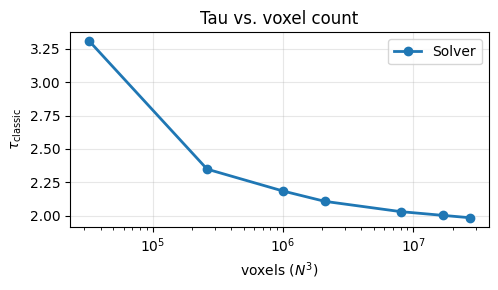

In [3]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
x_voxels = df_solver['N'] ** 3
ax.plot(x_voxels, df_solver['taufactor'], marker='o', linewidth=2, color='#1f77b4', label='Solver')
ax.set_xscale('log')
ax.set_xlabel('voxels ($N^3$)')
ax.set_ylabel('$\\tau_\\text{classic}$')
ax.set_title('Tau vs. voxel count')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()
plt.show()

## Solver Cross-Comparison (Wall Time and RAM)

In [4]:
solver_specs = [
    {'solver': 'Solver', 'label': 'Solver', 'solver_kwargs': {}},
    {'solver': 'PeriodicSolver', 'label': 'PeriodicSolver', 'solver_kwargs': {}},
    {'solver': 'AnisotropicSolver', 'label': 'AnisotropicSolver', 'solver_kwargs': {'spacing': (1.0, 1.0, 1.0)}},
    {'solver': 'MultiPhaseSolver', 'label': 'MultiPhaseSolver', 'solver_kwargs': {'cond': {1: 1.0}}},
]

all_rows = []
for spec in solver_specs:
    print(f"Running {spec['label']}...")
    rows = run_benchmark_study(
        Ns=Ns,
        devices=['cuda'],
        conv_crit_values=[1e-3],
        solver=spec['solver'],
        solver_kwargs=spec['solver_kwargs'],
        outfile='fcc_benchmark_results.txt',
        write_file=True,
    )
    for r in rows:
        r['solver_label'] = spec['label']
    all_rows.extend(rows)

df_compare = pd.DataFrame(all_rows)
# df_compare

Running Solver...
Running PeriodicSolver...
Running AnisotropicSolver...
Running MultiPhaseSolver...


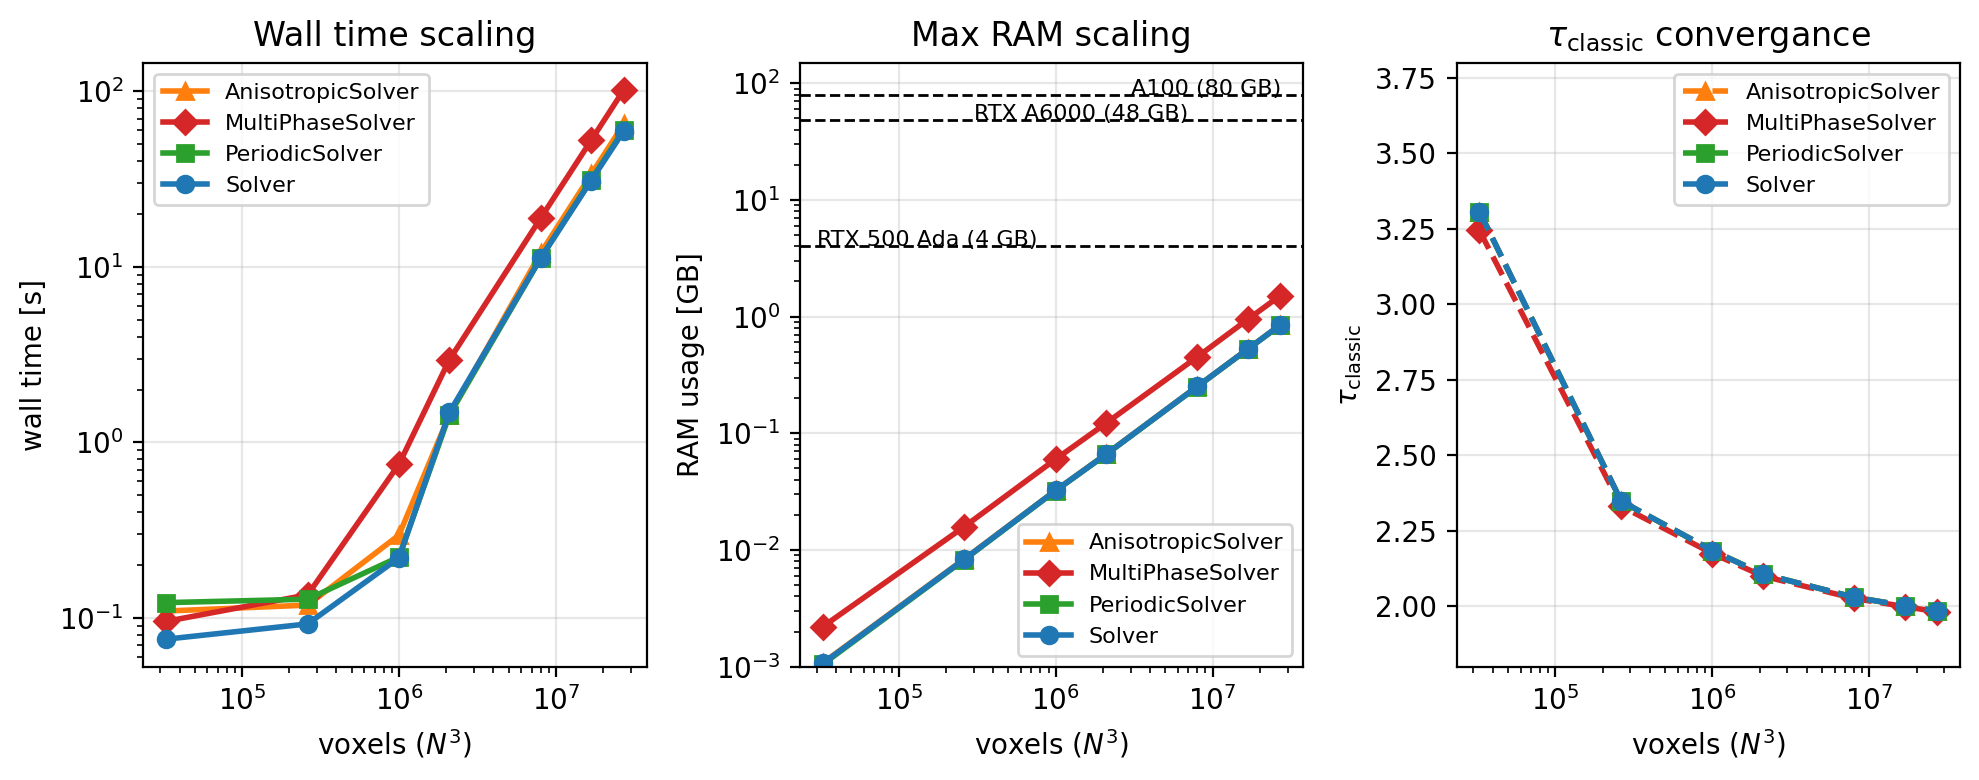

In [5]:
colors = {
    'Solver': '#1f77b4',
    'PeriodicSolver': '#2ca02c',
    'AnisotropicSolver': '#ff7f0e',
    'MultiPhaseSolver': '#d62728',
}
markers = {
    'Solver': 'o',
    'PeriodicSolver': 's',
    'AnisotropicSolver': '^',
    'MultiPhaseSolver': 'D',
}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), dpi=200)
for label, g in df_compare.groupby('solver_label'):
    g = g.sort_values('N')
    x = g['N'] ** 3
    ax1.loglog(
        x, g['solve_time'], marker=markers.get(label, 'o'), linewidth=2,
        color=colors.get(label), label=label
    )
    ax2.loglog(
        x, g['torch_max']/1024, marker=markers.get(label, 'o'), linewidth=2,
        color=colors.get(label), label=label
    )
    ax3.semilogx(
        x, g['taufactor'], marker=markers.get(label, 'o'), linewidth=2,
        color=colors.get(label), label=label, linestyle='--'
    )

# Hardware reference lines when using CUDA
for x, y, txt in [(3e4, 4, 'RTX 500 Ada (4 GB)'), (3e5, 48, 'RTX A6000 (48 GB)'), (3e6, 80, 'A100 (80 GB)')]:
    ax2.axhline(y, color='black', linestyle='--', linewidth=1)
    ax2.text(x, y, txt, fontsize=8, color='black')

ax1.set_xlabel('voxels ($N^3$)')
ax1.set_ylabel('wall time [s]')
ax1.set_title('Wall time scaling')
ax1.legend(loc='best', fontsize=8)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('voxels ($N^3$)')
ax2.set_ylabel('RAM usage [GB]')
ax2.set_title('Max RAM scaling')
ax2.legend(loc='best', fontsize=8)
ax2.set_ylim(0.001, 150)
ax2.grid(True, alpha=0.3)

ax3.set_xlabel('voxels ($N^3$)')
ax3.set_ylabel('$\\tau_\\text{classic}$')
ax3.set_title('$\\tau_\\text{classic}$ convergance')
ax3.legend(loc='best', fontsize=8)
ax3.set_ylim(1.8, 3.8)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
summary = (
    df_compare.groupby('solver_label', as_index=False)
    .agg(
        wall_time_mean_s=('solve_time', 'mean'),
        wall_time_max_s=('solve_time', 'max'),
        ram_peak_MB=('torch_max', 'max'),
        max_iterations=('iterations', 'max'),
    )
    .sort_values('wall_time_mean_s')
)
summary

,solver_label,wall_time_mean_s,wall_time_max_s,ram_peak_MB,max_iterations
3,Solver,14.790457,59.3705,869.22,2400
2,PeriodicSolver,14.986957,60.3890,867.12,2400
0,AnisotropicSolver,16.090500,65.0049,870.30,2400
1,MultiPhaseSolver,25.316057,101.6438,1551.87,2400
